In [1]:
#import necessary libraries and files 
import pandas as pd
import numpy as np
import warnings
import time
import datetime as dt 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import folium
import sklearn
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
import statsmodels.api as sm

import statsmodels.formula.api as smf
import plotly.express as px
pd.set_option("display.max_columns",1000)
pd.set_option('display.max_rows', 17544) 
%matplotlib inline

In [2]:
d = pd.read_csv('/Users/sreevathsadb/Masters/Project/Data/Bike_Trips_2013_2018.csv')

In [3]:
trip_df = d.groupby(['id','Cluster','year','month','day'])['interactions', 'rebalance','bike_arr_dep'].sum().reset_index()
trip_df.head(5)
trip_df['transformed_interactions'] = (trip_df['interactions'] + abs(trip_df['bike_arr_dep']) - trip_df['rebalance'])
active_stations_df = d.groupby(['id','Cluster','year','month','day'])['interactions'].count().reset_index(name ='activity_count')

In [4]:
df_sam = pd.merge(trip_df, active_stations_df, on = ['id','Cluster','year','month','day'], how = 'inner')
df_sam = df_sam[['transformed_interactions','interactions','activity_count']]
df_sam['activity_count_sq'] = df_sam['activity_count'] * df_sam['activity_count']
df_sam.sample(5)

,transformed_interactions,interactions,activity_count,activity_count_sq
92219,199.0,220.0,84,7056
14766,131.0,126.0,62,3844
125348,108.0,126.0,54,2916
9721,90.0,106.0,50,2500
44858,154.0,153.0,78,6084


### SAM Basic Model

The final model sums interactions for each station throughout the day, zDsd, defined in Eq. (3). Based on the assumption that stations with high usage experience more interaction collisions than those with lower usage, this method is designed to reduce the aggregation of values of differing variance. This station aggregation model (SAM) is BSS size agnostic and only uses the frequency of station use throughout the day (Eq. (17)) not the number of active stations in the system.

## Assumptions for Linear Regression

### Linearity

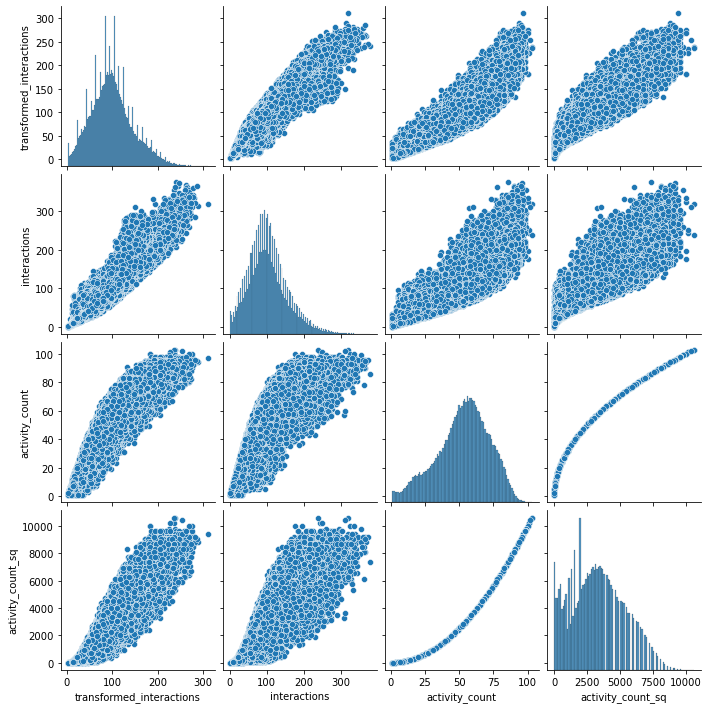

In [5]:
### Pairs Plot
p = sns.pairplot(df_sam)

From the above plot we can see that there is a linear relationship between tranformed_interactions and the interactions. So the Linearity assumption is satisfied.

### Training and Testing SAM Model

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(df_sam,df_sam, test_size = 0.3,random_state=0)
cdam_model = smf.ols(formula='transformed_interactions ~ 0 + interactions + activity_count + activity_count_sq', data=xtrain).fit()
y_pred = cdam_model.predict(xtest)
print(cdam_model.summary())

                                    OLS Regression Results                                   
Dep. Variable:     transformed_interactions   R-squared (uncentered):                   0.992
Model:                                  OLS   Adj. R-squared (uncentered):              0.992
Method:                       Least Squares   F-statistic:                          3.885e+06
Date:                      Tue, 26 Jul 2022   Prob (F-statistic):                        0.00
Time:                              20:13:42   Log-Likelihood:                     -3.6973e+05
No. Observations:                     99241   AIC:                                  7.395e+05
Df Residuals:                         99238   BIC:                                  7.395e+05
Df Model:                                 3                                                  
Covariance Type:                  nonrobust                                                  
                        coef    std err          t      P>|t

### Mean of Residuals
Residuals as we know are the differences between the true value and the predicted value. One of the assumptions of linear regression is that the mean of the residuals should be zero. So let's find out.

In [7]:
residuals = xtest['transformed_interactions']-y_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))
print("NRMSE {}".format(np.sqrt(mean_squared_error(xtest['transformed_interactions'], y_pred))/(xtest['transformed_interactions'].mean())))


Mean of Residuals 0.30017497800853565
NRMSE 0.10136263419554808


In [8]:
residuals.describe()

count    42532.000000
mean         0.300175
std         10.026317
min        -67.994210
25%         -5.771175
50%         -0.340516
75%          5.790522
max         52.908416
dtype: float64

### Detecting heteroscedasticity!

Homoscedasticity means that the residuals have equal or almost equal variance across the regression line. By plotting the error terms with predicted terms we can check that there should not be any pattern in the error terms.

In [9]:
y_pred.describe()

count    42532.000000
mean        98.658303
std         44.987480
min          1.139093
25%         67.784241
50%         96.668986
75%        126.596790
max        292.977166
dtype: float64

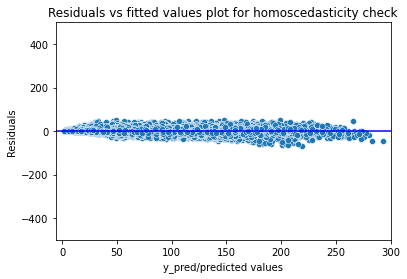

In [10]:
p = sns.scatterplot(y_pred,residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-500,500)
plt.xlim(-6,300)
p = sns.lineplot([-60,6000],[0,0],color='blue')
p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

Checking heteroscedasticity : Using Goldfeld Quandt we test for heteroscedasticity.

Null Hypothesis: Error terms are homoscedastic.

Alternative Hypothesis: Error terms are heteroscedastic.

In [11]:
X_train =  xtest.drop(["transformed_interactions"],axis=1)
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, X_train)
lzip(name, test)

[('F statistic', 1.0091666571188267), ('p-value', 0.252935719783884)]

Since p value is more than 0.05 in Goldfeld Quandt Test, we can't reject it's null hypothesis that error terms are homoscedastic. Good

### Check for Normality of error terms/residuals

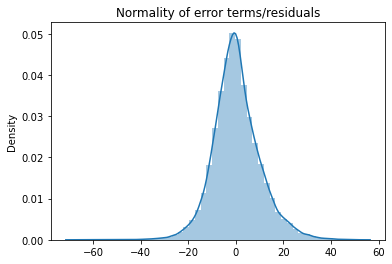

In [12]:
p = sns.distplot(residuals,kde=True)
p = plt.title('Normality of error terms/residuals')

The residual terms are pretty much normally distributed for the number of test points we took. Remember the central limit theorem which says that as the sample size increases the distribution tends to be normal. A skew is also visible from the plot. It's very difficult to get perfect curves, distributions in real life data.

### Autocorrelation of residuals

When the residuals are autocorrelated, it means that the current value is dependent of the previous (historic) values and that there is a definite unexplained pattern in the Y variable that shows up in the error terms. Though it is more evident in time series data.

Checking for autocorrelation To ensure the absence of autocorrelation we use Ljungbox test.

Null Hypothesis: Autocorrelation is absent.

Alternative Hypothesis: Autocorrelation is present.

In [13]:
from statsmodels.stats import diagnostic as diag
min(diag.acorr_ljungbox(residuals , lags = 40)[1])

0.5024147505465011

Since p value is greater than 0.05 we fail reject null hypothesis. Hence Auto Correlation is not  present.

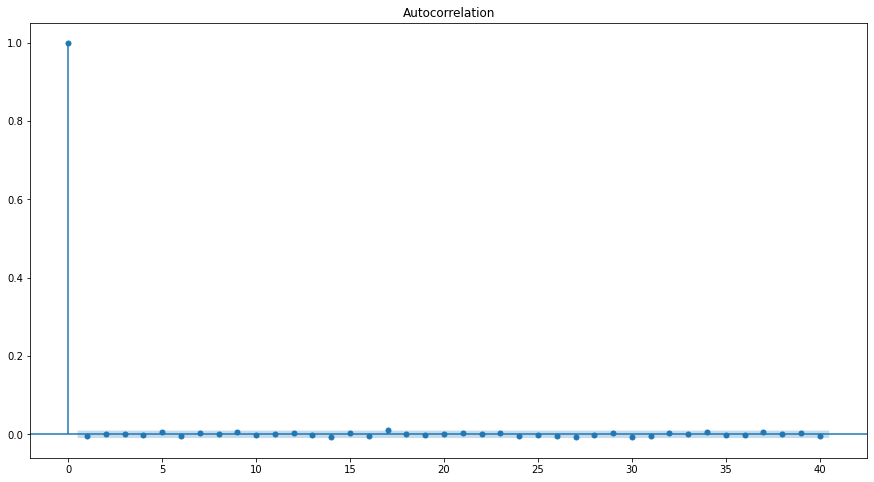

In [14]:
plt.rcParams["figure.figsize"] = (15,8)
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()

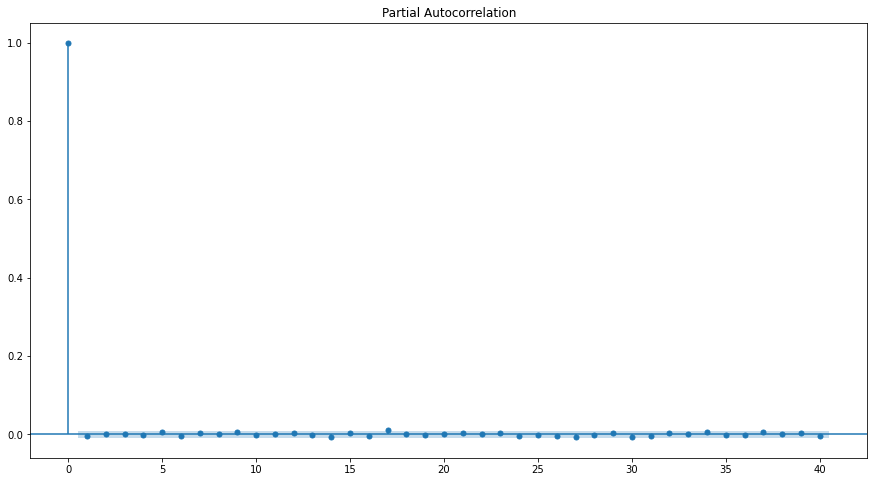

In [15]:
plt.rcParams["figure.figsize"] = (15,8)
sm.graphics.tsa.plot_pacf(residuals, lags=40)
plt.show()

There results doesn't show any auto correlation, as we couldnt see any spikes outsided the blue confidence interval region.

Reference : https://www.kaggle.com/code/shrutimechlearn/step-by-step-assumptions-linear-regression/notebook